In [16]:
try:
  import anvil.server
except:
  !pip install anvil-uplink
  import anvil.server

import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [17]:
# Load data file from Kaggle into a dataframe
file_path = "loan_data.csv"
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "taweilo/loan-approval-classification-data",
  file_path,
)

# Categorizing text values to integers
df.columns = [col.strip(' ') for col in df.columns]
df['default'] = df['previous_loan_defaults_on_file'].map({
    'No': 1,
    'Yes': 0
})
df['gender_binary'] = df['person_gender'].map({
    'male': 1,
    'female': 0
})
df['person_home_ownership_bin'] = df['person_home_ownership'].map({
    'RENT': 2,
    'OWN': 1,
    'MORTGAGE': 0
})
df['person_education_bin'] = df['person_education'].map({
    'Master': 3,
    'Bachelor': 2,
    'Associate': 1,
    'High School': 0
})

In [18]:
# Create new dataframe with only integer/float values
dfnumeric = df[['person_age', 'person_income',
       'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'default', 'gender_binary', 'person_home_ownership_bin',
       'person_education_bin', 'loan_status']]
# Drop all NaN rows
dfnumeric = dfnumeric.dropna()
# Correlate the data - gives us a better idea of what we're working with
dfnumeric.corr()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,default,gender_binary,person_home_ownership_bin,person_education_bin,loan_status
person_age,1.000000,0.196031,0.953647,0.052568,0.013691,-0.042408,0.860561,0.169461,0.023230,0.015928,-0.038667,-0.036717,-0.022006
person_income,0.196031,1.000000,0.188233,0.241544,0.001175,-0.232821,0.125408,0.034989,-0.062040,0.009996,-0.216085,-0.000883,-0.136160
person_emp_exp,0.953647,0.188233,1.000000,0.046289,0.016785,-0.038959,0.822249,0.177999,0.026743,0.013569,-0.035804,-0.038216,-0.020898
loan_amnt,0.052568,0.241544,0.046289,1.000000,0.145316,0.593650,0.044698,0.008842,0.059660,0.010186,-0.146971,0.001131,0.107895
loan_int_rate,0.013691,0.001175,0.016785,0.145316,1.000000,0.124955,0.018624,0.012402,0.180949,0.004196,0.132248,0.003142,0.331399
loan_percent_income,-0.042408,-0.232821,-0.038959,0.593650,0.124955,1.000000,-0.031543,-0.011078,0.203554,-0.000876,0.144947,-0.004841,0.384926
cb_person_cred_hist_length,0.860561,0.125408,0.822249,0.044698,0.018624,-0.031543,1.000000,0.146392,0.019929,0.010495,-0.030051,-0.038503,-0.015273
credit_score,0.169461,0.034989,0.177999,0.008842,0.012402,-0.011078,0.146392,1.000000,0.182889,0.000791,-0.004696,0.198189,-0.006431
default,0.023230,-0.062040,0.026743,0.059660,0.180949,0.203554,0.019929,0.182889,1.000000,-0.000608,0.131337,0.036494,0.544041
gender_binary,0.015928,0.009996,0.013569,0.010186,0.004196,-0.000876,0.010495,0.000791,-0.000608,1.000000,-0.000814,-0.004416,-0.000978


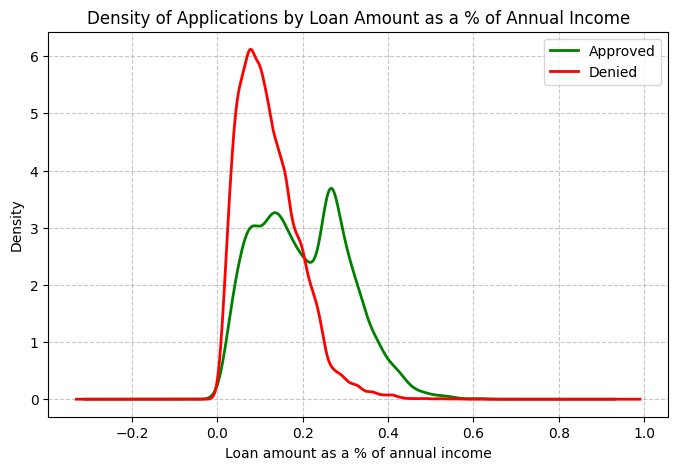

In [19]:
dfsub = df.dropna(subset=['loan_percent_income', 'loan_status'])

# Split data into approved and denied
approved = dfsub[dfsub['loan_status'] == 1]['loan_percent_income']
rejected = dfsub[dfsub['loan_status'] == 0]['loan_percent_income']

# Create density plots
plt.figure(figsize=(8,5))

approved.plot(kind='density', label='Approved', color='green', linewidth=2)
rejected.plot(kind='density', label='Denied', color='red', linewidth=2)

# Add titles and labels
plt.title('Density of Applications by Loan Amount as a % of Annual Income')
plt.xlabel('Loan amount as a % of annual income')
plt.ylabel('Density')

# Add legend and grid
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

# Show plot
plt.show()

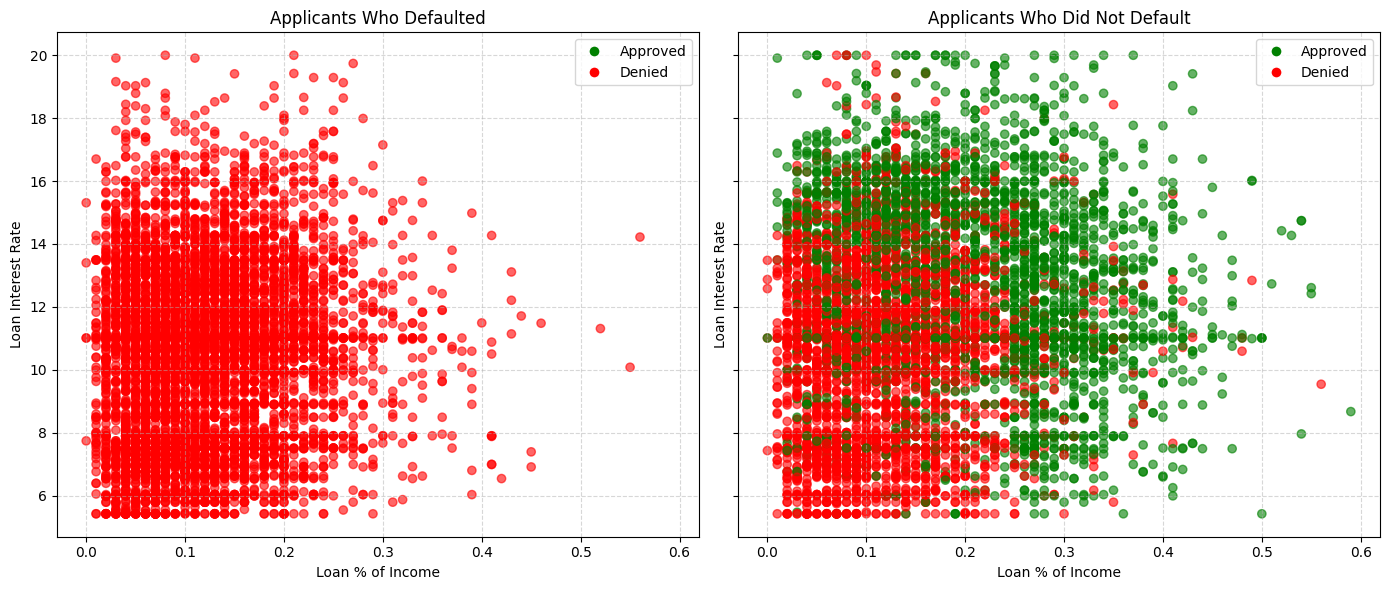

In [20]:

# Sample the data
df_sampled = df.sample(frac=0.3)
# Split datasets
defaulted = df_sampled[df_sampled['default'] == 0]
not_defaulted = df_sampled[df_sampled['default'] == 1]

# Define color mapping for loan_status
color_map = {
    1 : 'green',
    0 : 'red'
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot: Defaulted
axes[0].scatter(
    defaulted['loan_percent_income'],
    defaulted['loan_int_rate'],
    c=defaulted['loan_status'].map(color_map),
    alpha=0.6,
    label='Defaulted'
)
axes[0].set_title('Applicants Who Defaulted')
axes[0].set_xlabel('Loan % of Income')
axes[0].set_ylabel('Loan Interest Rate')

# Plot: Not Defaulted
axes[1].scatter(
    not_defaulted['loan_percent_income'],
    not_defaulted['loan_int_rate'],
    c=not_defaulted['loan_status'].map(color_map),
    alpha=0.6,
    label='Not Defaulted'
)
axes[1].set_title('Applicants Who Did Not Default')
axes[1].set_xlabel('Loan % of Income')
axes[1].set_ylabel('Loan Interest Rate')

# Add legends and grid
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.5)
    approved_patch = plt.Line2D([0], [0], marker='o', color='w', label='Approved',
                                markerfacecolor='green', markersize=8)
    rejected_patch = plt.Line2D([0], [0], marker='o', color='w', label='Denied',
                                markerfacecolor='red', markersize=8)
    ax.legend(handles=[approved_patch, rejected_patch])

plt.tight_layout()
plt.show()


In [21]:
# Splitting the data
X = dfnumeric[['loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'default', 'person_home_ownership_bin']]
y = dfnumeric['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [22]:
# initialize the model
model = LogisticRegression(max_iter=350)

In [23]:
# train the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=350)

In [24]:
# predict using test data
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [25]:
# Calculate model accuracy (compare predicted to actual)
accuracy = sum(y_pred == y_test) / len(y_test)
accuracy

0.8891482792378944

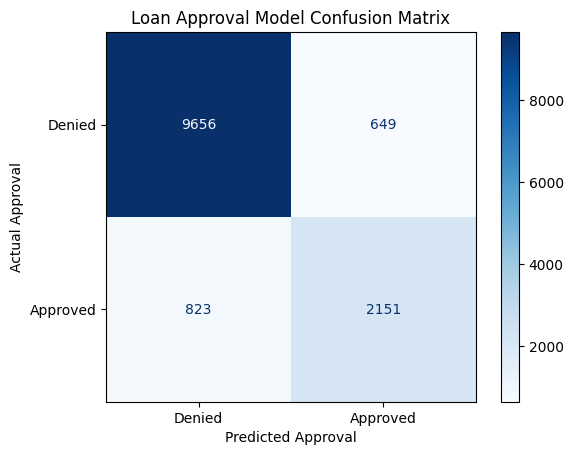

In [26]:
# Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
color_map = {
    1 : 'green',
    0 : 'red'
}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Denied", "Approved"]) # Replace with your actual labels
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted Approval")
plt.ylabel("Actual Approval")
plt.title("Loan Approval Model Confusion Matrix")
plt.show()

In [27]:
# Front End
anvil.server.connect("server_RGDXKV6EAEFLVYYD3CLMSPPW-CESO6KW4DVHSYDU3")

In [28]:
@anvil.server.callable
def classify_loan(loan_amount, int_rate, income, default, homeownership):
    # calculate Loan amount as a percentage of annual income
    loan_percent_income = loan_amount / income
    # create dataframe from input
    loan_profile = pd.DataFrame({
    "loan_amnt" : [loan_amount],
    "loan_int_rate" : [int_rate],
    "loan_percent_income" : [loan_percent_income],
    "default": [default],
    "person_home_ownership_bin": [homeownership]
    })
    status = model.predict(loan_profile)
    # output
    if status[0] == 1:
        string = "Approved. Calculated with " + f"{accuracy:.2f}" + "% accuracy."
        return string
    else:
        string = "Denied. Calculated with " + f"{accuracy:.2f}" + "% accuracy."
        return string

In [29]:
# Stop this cell to stop waiting
anvil.server.wait_forever()

KeyboardInterrupt: 

In [30]:
# Uncomment the following line and run this cell to disconnect from the server:
# anvil.server.disconnect()